# Препроцессинг

In [29]:
import pandas as pd

df_train = pd.read_parquet("train.parquet")
df_test = pd.read_parquet("test.parquet").reset_index(drop=True)
# df_test
df_train


,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.00000,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.00000,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.00000,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,2789,False,34666,вася-nicotine,4.00000,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,12834,False,26389,Lim Market,4.60000,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...
...,...,...,...,...,...,...,...,...
99987,114402,14922,False,4955,СТЕКЛОФФ ПРО,3.62069,"{""title"": ""Прочное стекло 2D на Samsung Galaxy...",Все категории->Электроника->Смартфоны и телефо...
99988,1594500,13028,False,19626,Hobby room,5.00000,"{""title"": ""Алмазная мозаика \""Ромашки\"" 40*50с...","Все категории->Хобби и творчество->Пазлы, моза..."
99989,790493,13407,False,22291,Море открыток,5.00000,"{""title"": ""Открытка \""Вместе навсегда\"" в краф...",Все категории->Товары для дома->Товары для пра...
99990,114509,12100,False,2985,Oppa Market,5.00000,"{""title"": ""Пульт K10B-C1 для Rolsen"", ""descrip...",Все категории->Электроника->Телевизоры и видео...


In [15]:
import ast
import numpy as np


def text_fields_to_columns(df):
    df["text_fields"] = df["text_fields"].apply(ast.literal_eval)
    for key in df["text_fields"][0].keys():
        df[key] = df["text_fields"].apply(
            lambda x: x[key] if len(x[key]) > 0 else np.nan
        )


text_fields_to_columns(df_train)
text_fields_to_columns(df_test)


In [16]:
def custom_chars_to_columns(df):
    not_na_custom_chars = df["custom_characteristics"][
        df["custom_characteristics"].notna()
    ]
    not_na_custom_chars = not_na_custom_chars.apply(lambda x: list(x.keys()))
    for i in range(3):
        df[f"custom_characteristics_{i}"] = not_na_custom_chars.apply(
            lambda x: x[i] if len(x) >= i + 1 else ""
        )
        df[f"custom_characteristics_{i}"] = df[f"custom_characteristics_{i}"].fillna("")


custom_chars_to_columns(df_train)
custom_chars_to_columns(df_test)


In [17]:
def defined_chars_to_columns(df):
    not_na_defined_chars = df["defined_characteristics"][
        df["defined_characteristics"].notna()
    ]
    not_na_defined_chars = not_na_defined_chars.apply(lambda x: list(x.keys()))
    for i in range(2):
        df[f"defined_characteristics_{i}"] = not_na_defined_chars.apply(
            lambda x: x[i] if len(x) >= i + 1 else ""
        )
        df[f"defined_characteristics_{i}"] = df[f"defined_characteristics_{i}"].fillna(
            ""
        )


defined_chars_to_columns(df_train)
defined_chars_to_columns(df_test)


In [18]:
import re


def clean_html_from_description(df):
    clean_regexp = re.compile("<.*?>")
    df["description"] = df["description"].str.replace(clean_regexp, "")


clean_html_from_description(df_train)
clean_html_from_description(df_test)


In [19]:
columns_to_drop = [
    "shop_id",
    "text_fields",
    "custom_characteristics",
    "defined_characteristics",
]
# df_train = df_train.drop(columns=columns_to_drop + ['category_name'])
df_train = df_train.drop(columns=columns_to_drop)

df_test = df_test.drop(columns=columns_to_drop)


<Axes: >

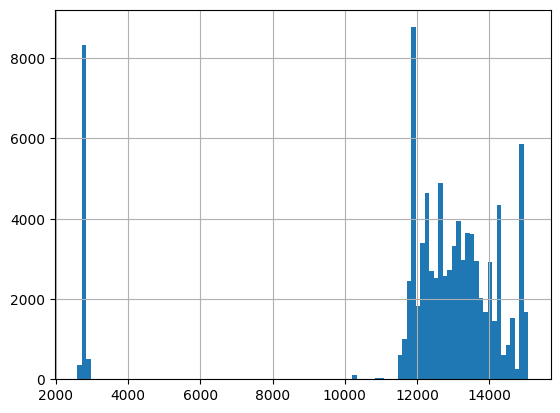

In [25]:
df_train["category_id"].hist(bins=100)


In [30]:
df_train["category_id"].value_counts()


11937    6590
14922    3709
13651    1463
13143    1460
12980    1222
         ... 
12808       2
12901       1
11549       1
11875       1
12836       1
Name: category_id, Length: 874, dtype: int64

In [31]:
df_train["category_id"].unique().shape


(874,)

In [27]:
df_train = df_train.groupby("category_id").filter(lambda x: len(x) >= 10)
df_train.shape


(90250, 8)

In [9]:
categories = df_train["category_id"].unique()
true_category_to_target = dict(zip(categories, list(range(len(categories)))))
df_train["target"] = df_train["category_id"].replace(true_category_to_target)


<Axes: >

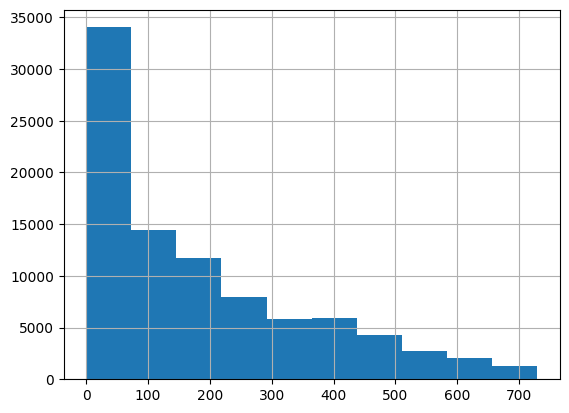

In [10]:
df_train["target"].hist()


In [11]:
df_train["target"].unique().shape


(730,)

In [12]:
for c in df_train.columns[df_train.dtypes == object]:
    df_train[c] = df_train[c].astype(str)

for c in df_test.columns[df_test.dtypes == object]:
    df_test[c] = df_test[c].astype(str)


In [13]:
def remove_unnecessary(df):
    df["title"] = df["title"].str.replace(r"\w*\d\w*", " ", regex=True)
    df["description"] = df["description"].str.replace(r"\w*\d\w*", " ", regex=True)

    df["title"] = df["title"].str.replace(" [^\w\s]+ ", " ", regex=True)
    df["description"] = df["description"].str.replace(" [^\w\s]+ ", " ", regex=True)

    df["title"] = df["title"].str.replace("&nbsp", " ", regex=False)
    df["description"] = df["description"].str.replace("&nbsp", " ", regex=False)

    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    df["title"] = df["title"].str.replace(emoji_pattern, " ", regex=True)
    df["description"] = df["description"].str.replace(emoji_pattern, " ", regex=True)

    df["title"] = df["title"].str.replace("http\S+", " ", regex=True)
    df["description"] = df["description"].str.replace("http\S+", " ", regex=True)

    df["title"] = df["title"].str.replace("youtu.be", " ", regex=True)
    df["description"] = df["description"].str.replace("youtu.be", " ", regex=True)

    df["title"] = df["title"].str.replace(r'"*"', " ", regex=True)
    df["description"] = df["description"].str.replace(r'"*"', " ", regex=True)

    df["title"] = df["title"].str.replace(r"(шт|см)", " ", regex=True)
    df["description"] = df["description"].str.replace(r"(шт|см)", " ", regex=True)

    df["title"] = df["title"].str.replace(" +", " ", regex=True)
    df["description"] = df["description"].str.replace(" +", " ", regex=True)

    df["title"] = df["title"].str.strip()
    df["description"] = df["description"].str.strip()


for _ in range(3):
    remove_unnecessary(df_train)
    remove_unnecessary(df_test)


In [30]:
df_train["last_category"] = (
    df_train["category_name"].str.extract(r".+(->.+)$")[0].str.replace("->", "")
)
df_train["last_category"] = df_train["last_category"].str.replace(r"[^\w\s]", "")


In [31]:
import pymorphy2
import swifter

morph_analyzer = pymorphy2.MorphAnalyzer(lang="ru")


def converter(sentence):
    normal_forms = []
    words = sentence.split()
    for item in words:
        normal_forms.append(morph_analyzer.parse(item)[0].normal_form)
    return normal_forms


df_train["last_category"] = df_train["last_category"].swifter.apply(converter)


Pandas Apply:   0%|          | 0/90250 [00:00<?, ?it/s]

In [35]:
category_tags = [
    item for sublist in df_train["last_category"].to_list() for item in sublist
]
category_tags = set(category_tags)


In [ ]:
len(category_tags)


In [ ]:
list_of_tags = list(category_tags)
column_names = [f"title_has_tag_{i}" for i in list_of_tags]


def find_tags(sentence):
    normal_forms = set()
    words = sentence.split()
    for item in words:
        normal_forms.add(morph_analyzer.parse(item)[0].normal_form)

    result = []
    for tag in list_of_tags:
        if tag in normal_forms:
            result.append(True)
        else:
            result.append(False)
    return pd.Series(result)


df_train[column_names] = df_train["title"].swifter.apply(find_tags)
df_test[column_names] = df_test["title"].swifter.apply(find_tags)


In [131]:
df_train.to_parquet("preprocessed_train.parquet")
df_test.to_parquet("preprocessed_test.parquet")
